<a href="https://colab.research.google.com/github/ayush-2405/Sudoku_Solver/blob/main/SudokuMain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [302]:
import cv2
import numpy as np
from models import *
from tensorflow.python.keras.models import Sequential, load_model
import imutils
import os
from skimage.segmentation import clear_border
from google.colab.patches import cv2_imshow
from imutils.perspective import four_point_transform
import torch, torchvision
from torchvision import transforms
import requests
from PIL import Image
from io import BytesIO
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
import pandas as pd

T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [303]:
def find_board(img,show = True, dilate = False ,erode = False):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)#converts colorspace from RGB to graysacle
  if show == True:
    cv2_imshow(cv2.resize(gray,(360,360)))
    cv2.waitKey(0)
    cv2.destroyAllWindows()

  bfilter = cv2.GaussianBlur(gray,(7,7),3) #adding a bilateral filter blur to remove noices while retaining smooth edges cv2.bilateralFilter(gray, 13, 20, 20)
  if show == True:
    cv2_imshow(cv2.resize(bfilter,(360,360)))
    cv2.waitKey(0)
    cv2.destroyAllWindows()

  #adaptive threshold method where the threshold value is calculated for smaller regions
  #max pixel  value to be given after thresholding is 255 ( white color)
  #ADAPTIVE_THRESH_GAUSSIAN_C − threshold value is the weighted sum of neighborhood values where weights are a Gaussian window.
  #cv2.THRESH_BINARY_INV - Inverts the case of binary thresholding
  #threshold uses 11 neighboring pixels
  threshold = cv2.adaptiveThreshold(bfilter, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
  if show == True:
    cv2_imshow(cv2.resize(threshold,(360,360)))
    cv2.waitKey(0)
    cv2.destroyAllWindows()

  processed_board = threshold
  #adding an option dilation and erosion

  if dilate == True:
    kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)
    image_processed = cv2.dilate(threshold, kernel)
  if erode == True:
    kernel = np.ones((5,5),np.uint8)
    image_processed = cv2.erode(image_processed,kernel,iterations = 1)

  original_board = img.copy()

  # find contours in the thresholded image and sort them by size in
	# descending order
  cntrs = cv2.findContours(processed_board.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  cntrs = imutils.grab_contours(cntrs)
  cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)
	# initialize a contour that corresponds to the sudoku outline
  boardCntr = None
  for c in cntrs:
		# approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    '''if our approximated contour has four points, then we can
     assume we have found the outline of the puzzle'''
    if len(approx) == 4:
      boardCntr = approx
      location= approx
      break

  # if the board contour is empty then our script could not find the sudoku board in the image
  if boardCntr is None:
    raise Exception(("Could not find Sudoku puzzle outline. "
			"Try debugging your thresholding and contour steps."))
  if show:
    output = original_board.copy()
    cv2.drawContours(output, [boardCntr], -1, (0, 255, 0), 2)
    cv2_imshow(cv2.resize(output,(360,360)))
    cv2.waitKey(0)

  image_warped = four_point_transform(original_board, boardCntr.reshape(4, 2))#Top-down view of original image
  img_warped = four_point_transform(processed_board, boardCntr.reshape(4, 2))#Top-Down view of grayscale image
	# check to see if we are visualizing the perspective transform
  if show:
		# show the output warped image (again, for debugging purposes)
    cv2_imshow(cv2.resize(img_warped,(360,360)))
    cv2.waitKey(0)
  return (img_warped, image_warped, location)

In [304]:
def digit_extract(img,position,img_size,grid_size,extracted_img_size,show = True):
  image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Converting to grayscale
  processed_image = image_gray
  #height of each number block
  block_height = img_size[0]//grid_size[0]
  #width of each number block
  block_width = img_size[1]//grid_size[1]
  #top height of the digit box
  top_h = block_height*(position[0])
  #bottom height of the digit box
  bottom_h = top_h + block_height
  #left coordinate of the digit box
  left = block_width*(position[1])
  #right coordinate of the digit box
  right = left + block_width
  #cropping out the digit box
  digit = processed_image[top_h:bottom_h,left:right]

  #applying OTSU threshold with binary inversion
  digit = cv2.threshold(digit,0,255, cv2.THRESH_BINARY_INV |  cv2.THRESH_OTSU)[1]
  #clears objects connected to the image border
  digit = clear_border(digit)

  #finding the contours
  digit_contours = cv2.findContours(digit.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  #adds a counter to the contour
  digit_contours = imutils.grab_contours(digit_contours)
  #image masking
  if len(digit_contours)!=0: #checking if there are any contours in the image
    digit_contour = max(digit_contours, key=cv2.contourArea) #Finding the contour housing the largest area
    background = np.zeros(digit.shape,dtype = np.uint8) #Creating a  mask of the size of digit
    cv2.drawContours(background,[digit_contour],-1,255,-1) #drawing the digit contour on the mask
    digit = cv2.bitwise_and(digit,digit, mask=background) #bitwiseAND is true if and only if both pixels are greater than zero



  digit = cv2.resize(digit,extracted_img_size) #resizing the digit to desired output shape


  if show == True:
    cv2_imshow(digit)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

  return(digit)

In [305]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")

No Cuda Available


In [306]:
model = sudokuCnn(output_classes=10)

In [307]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('modelweights.pth', map_location=torch.device('cpu')))
model.to(device)

sudokuCnn(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [308]:
def predict(model,x):
    device = torch.device("cpu")
    model.eval()
    with torch.no_grad():
      x.to(device)
      scores = model(x)
      prediction = scores.argmax(1)

    return prediction

In [309]:
def digit_reader(model, device, image,img_size,grid_size,show=True):
  sudoku_array = []
  img = cv2.resize(image,img_size)
  cv2_imshow(img)
  for i in range(grid_size[0]):
    for j in range(grid_size[1]):
      digit = digit_extract(img,(i,j),img_size,grid_size,extracted_img_size=(28,28),show = show)
      digit = torch.tensor(digit)
      blank_threshold = (torch.sum(digit))
      if blank_threshold <=(255*15):
        sudoku_array.append(0)
        if (show==True):
          print(torch.tensor([0]))
      else:
        digit = digit.reshape((1,1,28,28)).float()

        model.eval()
        model = model.to(device = device)
        digit = digit.to(device)
        digit_read = predict(model,digit)

        digit_final = torch.mode(digit_read)
        if (show ==True):
          print(digit_read)
          sudoku_array.append(digit_final[0])

  sudoku_array = np.array(sudoku_array)
  return (sudoku_array)

# **SUDOKU_SOLVER**

In [436]:
def find_empty(board):
    """Checks where there is an empty or unsolved block."""
    for i in range(len(board)):
        for j in range(len(board[0])):
            if board[i][j] == 0:
                return (i, j)  # row, col
    return None

def isValid(board, num, pos):
    """Check if placing the number num at position pos is valid."""
    # Check row
    for i in range(len(board[0])):
        if board[pos[0]][i] == num and pos[1] != i:
            return False

    # Check column
    for i in range(len(board)):
        if board[i][pos[1]] == num and pos[0] != i:
            return False

    # Check submatrix(3 x 3)
    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y * 3, box_y * 3 + 3):
        for j in range(box_x * 3, box_x * 3 + 3):
            if board[i][j] == num and (i, j) != pos:
                return False

    return True

def solve(board):
    find = find_empty(board)
    if not find:
        return True
    else:
        row, col = find

    for i in range(1, 10):
        if isValid(board, i, (row, col)):
            board[row][col] = i

            if solve(board):
                return True

            board[row][col] = 0

    return False

def get_board(bo):
    if solve(bo):
        print(bo)
        return bo
    else:
        raise ValueError("The Sudoku puzzle is unsolvable")


In [366]:
def displayNumbers(img, numbers, color=(0, 255, 0)):
  W = int(img.shape[1]/9)
  H = int(img.shape[0]/9)
  for i in range (9):
    for j in range (9):
      if numbers[(j*9)+i] !=0:
        cv2.putText(img, str(numbers[(j*9)+i]), (i*W+int(W/2)-int((W/4)),int((j+0.7)*H)), cv2.FONT_HERSHEY_COMPLEX, 1, color, 2, cv2.LINE_AA)
  return img

# **1st Sudoku Board**

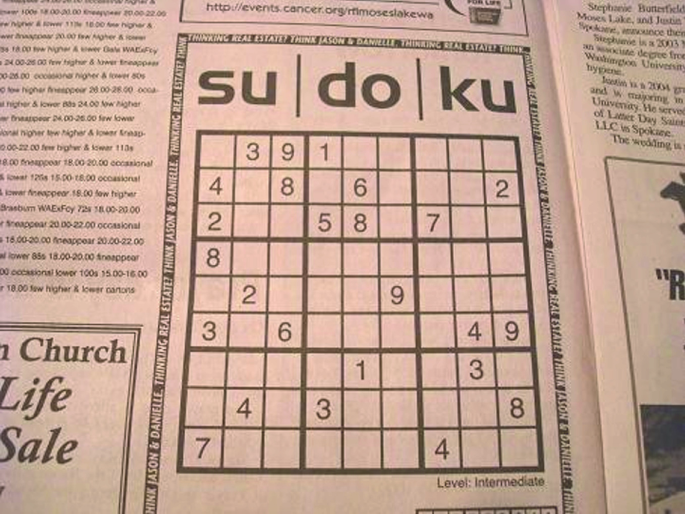

In [312]:
img = cv2.imread('/content/sudoku.png')
original_pic=(img)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

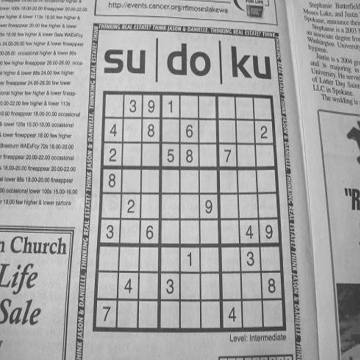

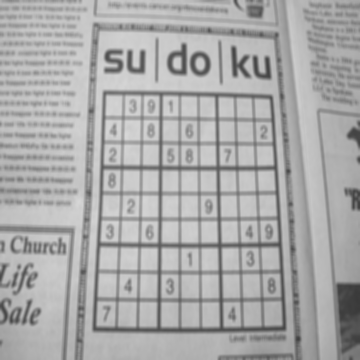

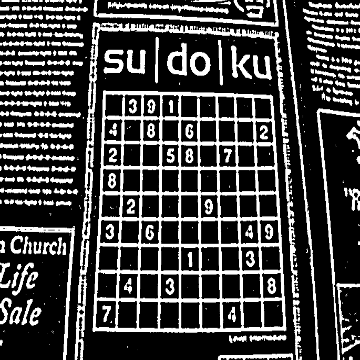

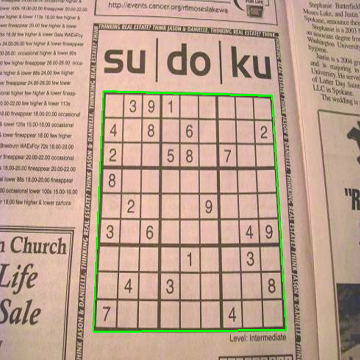

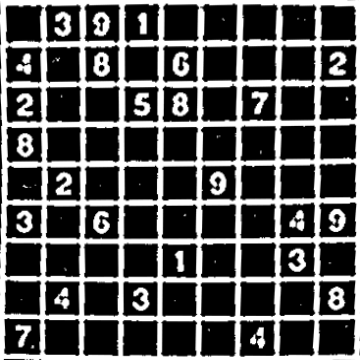

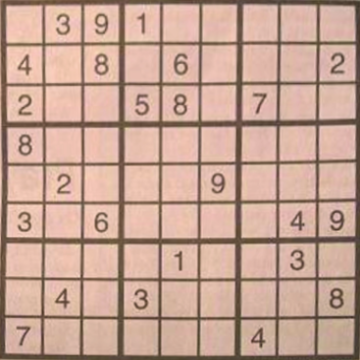

In [313]:
board= find_board(img)
cv2_imshow(cv2.resize(board[1],(360,360)))
cv2.waitKey(0)
cv2.destroyAllWindows()

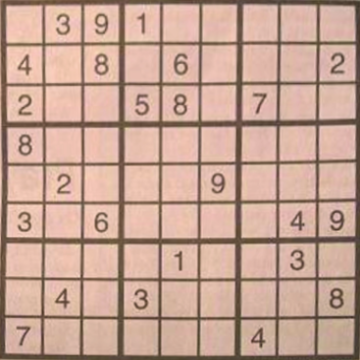

tensor([0])


tensor([3])


/content/models.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


tensor([9])


tensor([1])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([4])


tensor([0])


tensor([8])


tensor([0])


tensor([6])


tensor([0])


tensor([0])


tensor([0])


tensor([2])


tensor([2])


tensor([0])


tensor([0])


tensor([5])


tensor([8])


tensor([0])


tensor([7])


tensor([0])


tensor([0])


tensor([8])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([2])


tensor([0])


tensor([0])


tensor([0])


tensor([9])


tensor([0])


tensor([0])


tensor([0])


tensor([3])


tensor([0])


tensor([6])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([4])


tensor([9])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([1])


tensor([0])


tensor([0])


tensor([3])


tensor([0])


tensor([0])


tensor([4])


tensor([0])


tensor([3])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([8])


tensor([7])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([4])


tensor([0])


tensor([0])


In [314]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
unsolved_predicted=digit_reader(model, device, board[1],(360,360),(9,9),show=True)
sudoku_array=unsolved_predicted.reshape(9,9)

In [315]:
unsolved_predicted

array([0, 3, 9, 1, 0, 0, 0, 0, 0, 4, 0, 8, 0, 6, 0, 0, 0, 2, 2, 0, 0, 5,
       8, 0, 7, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 9, 0, 0,
       0, 3, 0, 6, 0, 0, 0, 0, 4, 9, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 4, 0,
       3, 0, 0, 0, 0, 8, 7, 0, 0, 0, 0, 0, 4, 0, 0])

In [316]:
sudoku_array

array([[0, 3, 9, 1, 0, 0, 0, 0, 0],
       [4, 0, 8, 0, 6, 0, 0, 0, 2],
       [2, 0, 0, 5, 8, 0, 7, 0, 0],
       [8, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 9, 0, 0, 0],
       [3, 0, 6, 0, 0, 0, 0, 4, 9],
       [0, 0, 0, 0, 1, 0, 0, 3, 0],
       [0, 4, 0, 3, 0, 0, 0, 0, 8],
       [7, 0, 0, 0, 0, 0, 4, 0, 0]])

In [317]:
grid=np.array(sudoku_array)
grid=grid.reshape(9,9)
grid

array([[0, 3, 9, 1, 0, 0, 0, 0, 0],
       [4, 0, 8, 0, 6, 0, 0, 0, 2],
       [2, 0, 0, 5, 8, 0, 7, 0, 0],
       [8, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 9, 0, 0, 0],
       [3, 0, 6, 0, 0, 0, 0, 4, 9],
       [0, 0, 0, 0, 1, 0, 0, 3, 0],
       [0, 4, 0, 3, 0, 0, 0, 0, 8],
       [7, 0, 0, 0, 0, 0, 4, 0, 0]])

In [321]:
output=get_board(grid)


[[5 3 9 1 7 2 6 8 4]
 [4 7 8 9 6 3 1 5 2]
 [2 6 1 5 8 4 7 9 3]
 [8 9 7 6 4 5 3 2 1]
 [1 2 4 8 3 9 5 7 6]
 [3 5 6 7 2 1 8 4 9]
 [9 8 5 4 1 6 2 3 7]
 [6 4 2 3 5 7 9 1 8]
 [7 1 3 2 9 8 4 6 5]]


[1 0 0 0 1 1 1 1 1 0 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1
 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 0 0 1
 1 1 1 1 0 1 1]


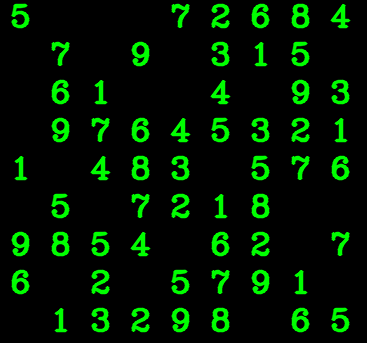

In [322]:
binArr = np.where(np.array(unsolved_predicted)>0, 0, 1)
print(binArr)
# get only solved numbers for the solved board
flat_solved_board_nums = output.flatten()*binArr
# create a mask
mask = np.zeros_like(board[1])
solved_board_mask = displayNumbers(mask, flat_solved_board_nums)
cv2_imshow(solved_board_mask)

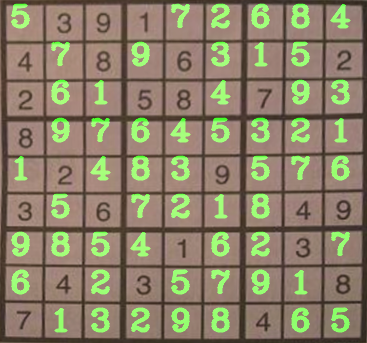

In [323]:
try:
  combined = cv2.addWeighted(board[1], 0.7, solved_board_mask, 1, 0)
  cv2_imshow(combined)
  cv2.waitKey(0)
except:
  print("Solution doesn't exist or Model misread digits.")

# **2nd Sudoku Board**

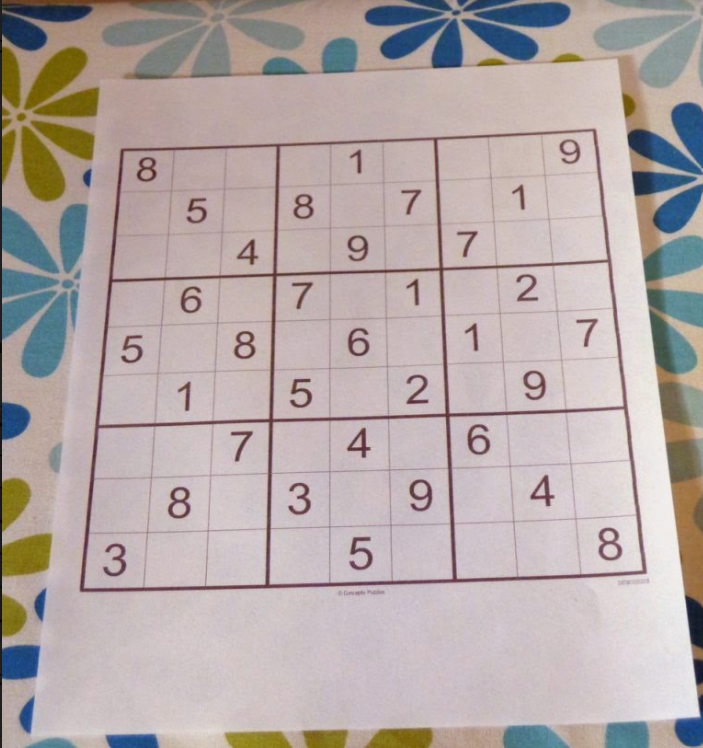

In [367]:
img2 = cv2.imread('/content/sudoku1.png')
original_pic2=(img2)
cv2_imshow(img2)
cv2.waitKey(0)
cv2.destroyAllWindows()

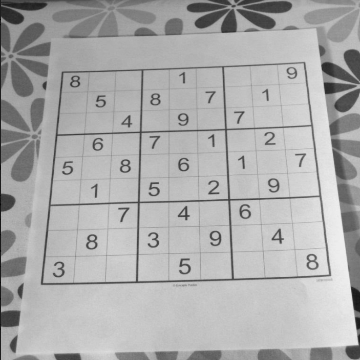

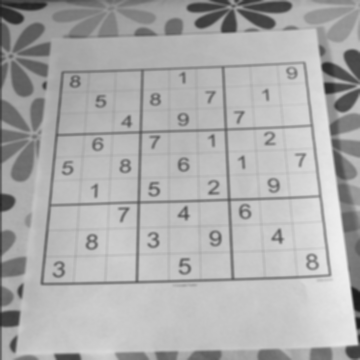

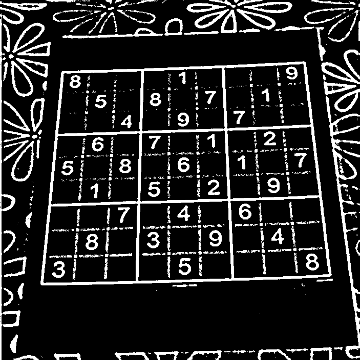

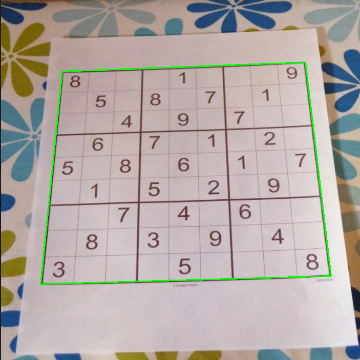

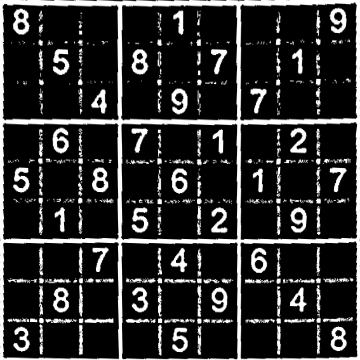

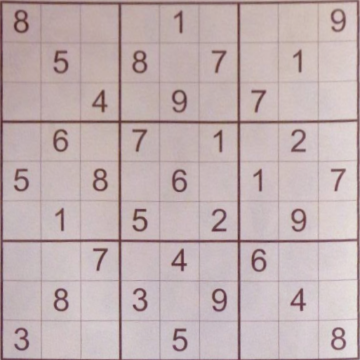

In [368]:
board2= find_board(img2)
cv2_imshow(cv2.resize(board2[1],(360,360)))
cv2.waitKey(0)
cv2.destroyAllWindows()

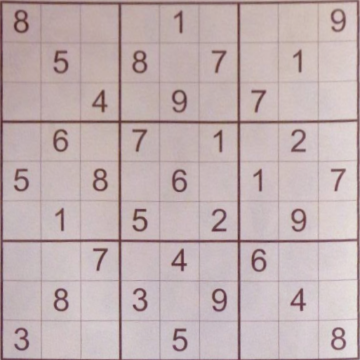

tensor([8])


/content/models.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


tensor([0])


tensor([0])


tensor([0])


tensor([1])


tensor([0])


tensor([0])


tensor([0])


tensor([9])


tensor([0])


tensor([5])


tensor([0])


tensor([8])


tensor([0])


tensor([7])


tensor([0])


tensor([1])


tensor([0])


tensor([0])


tensor([0])


tensor([4])


tensor([0])


tensor([9])


tensor([0])


tensor([7])


tensor([0])


tensor([0])


tensor([0])


tensor([6])


tensor([0])


tensor([7])


tensor([0])


tensor([1])


tensor([0])


tensor([2])


tensor([0])


tensor([5])


tensor([0])


tensor([8])


tensor([0])


tensor([6])


tensor([0])


tensor([1])


tensor([0])


tensor([7])


tensor([0])


tensor([1])


tensor([0])


tensor([5])


tensor([0])


tensor([2])


tensor([0])


tensor([9])


tensor([0])


tensor([0])


tensor([0])


tensor([7])


tensor([0])


tensor([4])


tensor([0])


tensor([6])


tensor([0])


tensor([0])


tensor([0])


tensor([8])


tensor([0])


tensor([3])


tensor([0])


tensor([9])


tensor([0])


tensor([4])


tensor([0])


tensor([3])


tensor([0])


tensor([0])


tensor([0])


tensor([5])


tensor([0])


tensor([0])


tensor([0])


tensor([8])


In [385]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
unsolved_predicted2=digit_reader(model, device, board2[1],(360,360),(9,9),show=True)
sudoku_array2=unsolved_predicted2.reshape(9,9)

In [386]:
unsolved_predicted2

array([8, 0, 0, 0, 1, 0, 0, 0, 9, 0, 5, 0, 8, 0, 7, 0, 1, 0, 0, 0, 4, 0,
       9, 0, 7, 0, 0, 0, 6, 0, 7, 0, 1, 0, 2, 0, 5, 0, 8, 0, 6, 0, 1, 0,
       7, 0, 1, 0, 5, 0, 2, 0, 9, 0, 0, 0, 7, 0, 4, 0, 6, 0, 0, 0, 8, 0,
       3, 0, 9, 0, 4, 0, 3, 0, 0, 0, 5, 0, 0, 0, 8])

In [384]:
sudoku_array2

array([[8, 7, 2, 4, 1, 3, 5, 6, 9],
       [9, 5, 6, 8, 2, 7, 3, 1, 4],
       [1, 3, 4, 6, 9, 5, 7, 8, 2],
       [4, 6, 9, 7, 3, 1, 8, 2, 5],
       [5, 2, 8, 9, 6, 4, 1, 3, 7],
       [7, 1, 3, 5, 8, 2, 4, 9, 6],
       [2, 9, 7, 1, 4, 8, 6, 5, 3],
       [6, 8, 5, 3, 7, 9, 2, 4, 1],
       [3, 4, 1, 2, 5, 6, 9, 7, 8]])

In [372]:
grid2=np.array(sudoku_array2)
grid2=grid2.reshape(9,9)
grid2

array([[8, 0, 0, 0, 1, 0, 0, 0, 9],
       [0, 5, 0, 8, 0, 7, 0, 1, 0],
       [0, 0, 4, 0, 9, 0, 7, 0, 0],
       [0, 6, 0, 7, 0, 1, 0, 2, 0],
       [5, 0, 8, 0, 6, 0, 1, 0, 7],
       [0, 1, 0, 5, 0, 2, 0, 9, 0],
       [0, 0, 7, 0, 4, 0, 6, 0, 0],
       [0, 8, 0, 3, 0, 9, 0, 4, 0],
       [3, 0, 0, 0, 5, 0, 0, 0, 8]])

In [380]:
output2=get_board(sudoku_array2)


[[8 7 2 4 1 3 5 6 9]
 [9 5 6 8 2 7 3 1 4]
 [1 3 4 6 9 5 7 8 2]
 [4 6 9 7 3 1 8 2 5]
 [5 2 8 9 6 4 1 3 7]
 [7 1 3 5 8 2 4 9 6]
 [2 9 7 1 4 8 6 5 3]
 [6 8 5 3 7 9 2 4 1]
 [3 4 1 2 5 6 9 7 8]]


[0 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1
 1 1 0 1 1 1 0]


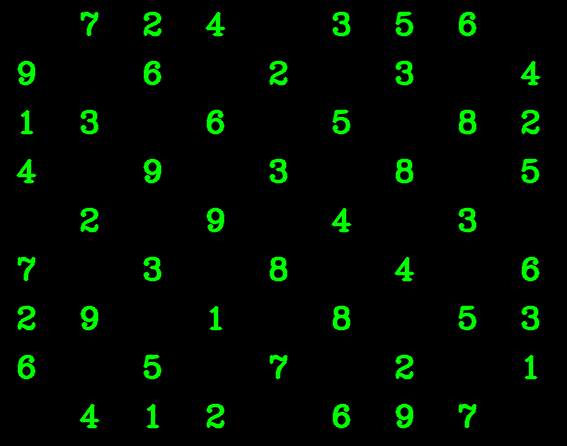

In [387]:
binArr2 = np.where(np.array(unsolved_predicted2)>0, 0, 1)
print(binArr2)
# get only solved numbers for the solved board
flat_solved_board_nums2 = output2.flatten()*binArr2
# create a mask
mask2 = np.zeros_like(board2[1])
solved_board_mask2= displayNumbers(mask2, flat_solved_board_nums2)
cv2_imshow(solved_board_mask2)

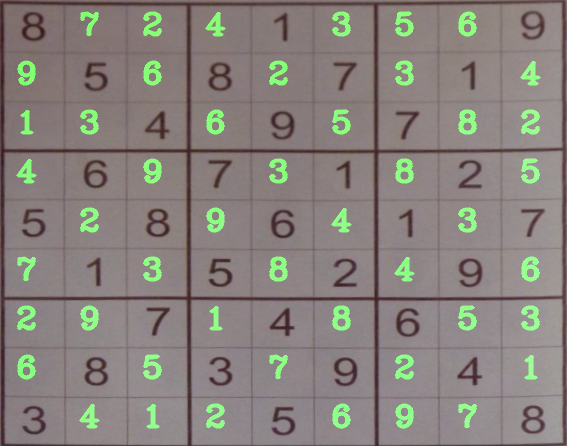

In [388]:
try:
  combined2 = cv2.addWeighted(board2[1], 0.7, solved_board_mask2, 1, 0)
  cv2_imshow(combined2)
  cv2.waitKey(0)
except:
  print("Solution doesn't exist or Model misread digits.")

# **3rd Sudoku Board**

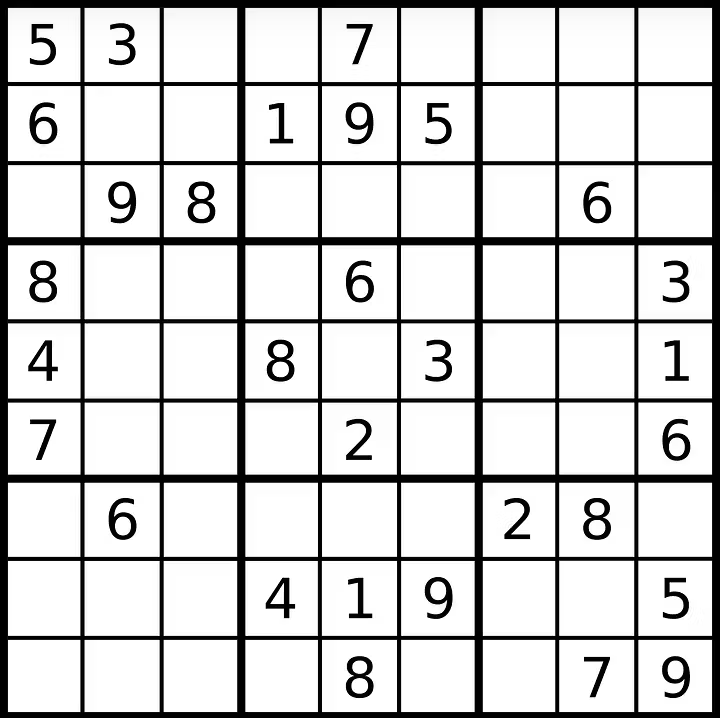

In [437]:
img3 = cv2.imread('/content/sudoku3.png')
original_pic3=(img3)
cv2_imshow(img3)
cv2.waitKey(0)
cv2.destroyAllWindows()

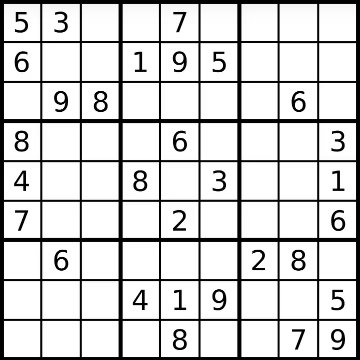

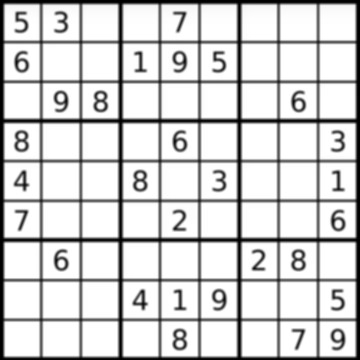

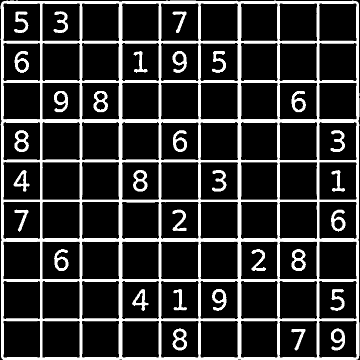

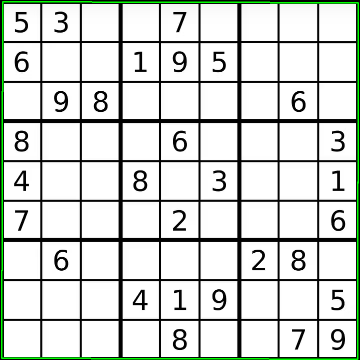

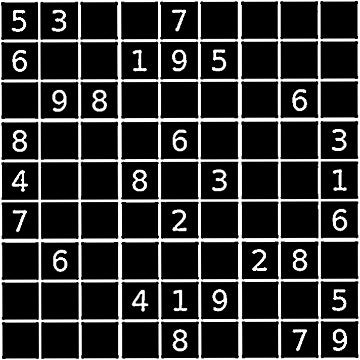

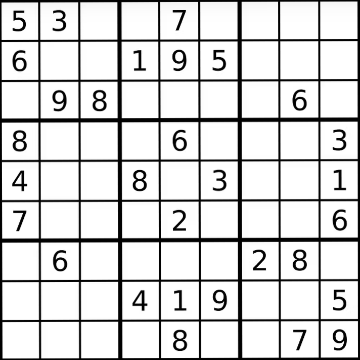

In [438]:
board3= find_board(img3)
cv2_imshow(cv2.resize(board3[1],(360,360)))
cv2.waitKey(0)
cv2.destroyAllWindows()

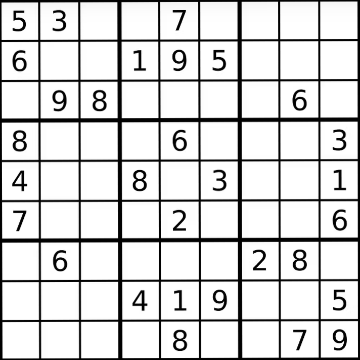

tensor([5])


tensor([3])


tensor([0])


tensor([0])


tensor([7])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([6])


tensor([0])


tensor([0])


tensor([1])


tensor([9])


tensor([5])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([9])


tensor([8])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([6])


tensor([0])


tensor([8])


tensor([0])


tensor([0])


tensor([0])


tensor([6])


tensor([0])


tensor([0])


tensor([0])


tensor([3])


tensor([4])


tensor([0])


tensor([0])


tensor([8])


tensor([0])


tensor([3])


tensor([0])


tensor([0])


tensor([1])


tensor([7])


tensor([0])


tensor([0])


tensor([0])


tensor([2])


tensor([0])


tensor([0])


tensor([0])


tensor([6])


tensor([0])


tensor([6])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([2])


tensor([8])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([4])


tensor([1])


tensor([9])


tensor([0])


tensor([0])


tensor([5])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([8])


tensor([0])


tensor([0])


tensor([7])


tensor([9])


In [444]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
unsolved_predicted3=digit_reader(model, device, board3[1],(360,360),(9,9),show=True)
sudoku_array3=unsolved_predicted3.reshape(9,9)

In [445]:
unsolved_predicted3

array([5, 3, 0, 0, 7, 0, 0, 0, 0, 6, 0, 0, 1, 9, 5, 0, 0, 0, 0, 9, 8, 0,
       0, 0, 0, 6, 0, 8, 0, 0, 0, 6, 0, 0, 0, 3, 4, 0, 0, 8, 0, 3, 0, 0,
       1, 7, 0, 0, 0, 2, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 2, 8, 0, 0, 0, 0,
       4, 1, 9, 0, 0, 5, 0, 0, 0, 0, 8, 0, 0, 7, 9])

In [441]:
grid3=np.array(sudoku_array3)
grid3=grid3.reshape(9,9)
grid3

array([[5, 3, 0, 0, 7, 0, 0, 0, 0],
       [6, 0, 0, 1, 9, 5, 0, 0, 0],
       [0, 9, 8, 0, 0, 0, 0, 6, 0],
       [8, 0, 0, 0, 6, 0, 0, 0, 3],
       [4, 0, 0, 8, 0, 3, 0, 0, 1],
       [7, 0, 0, 0, 2, 0, 0, 0, 6],
       [0, 6, 0, 0, 0, 0, 2, 8, 0],
       [0, 0, 0, 4, 1, 9, 0, 0, 5],
       [0, 0, 0, 0, 8, 0, 0, 7, 9]])

In [442]:
sudoku_array3

array([[5, 3, 0, 0, 7, 0, 0, 0, 0],
       [6, 0, 0, 1, 9, 5, 0, 0, 0],
       [0, 9, 8, 0, 0, 0, 0, 6, 0],
       [8, 0, 0, 0, 6, 0, 0, 0, 3],
       [4, 0, 0, 8, 0, 3, 0, 0, 1],
       [7, 0, 0, 0, 2, 0, 0, 0, 6],
       [0, 6, 0, 0, 0, 0, 2, 8, 0],
       [0, 0, 0, 4, 1, 9, 0, 0, 5],
       [0, 0, 0, 0, 8, 0, 0, 7, 9]])

In [443]:
output3=get_board(sudoku_array3)

[[5 3 4 6 7 8 9 1 2]
 [6 7 2 1 9 5 3 4 8]
 [1 9 8 3 4 2 5 6 7]
 [8 5 9 7 6 1 4 2 3]
 [4 2 6 8 5 3 7 9 1]
 [7 1 3 9 2 4 8 5 6]
 [9 6 1 5 3 7 2 8 4]
 [2 8 7 4 1 9 6 3 5]
 [3 4 5 2 8 6 1 7 9]]


[0 0 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0
 1 1 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0 0 0 1 1 0 1 1
 1 1 0 1 1 0 0]


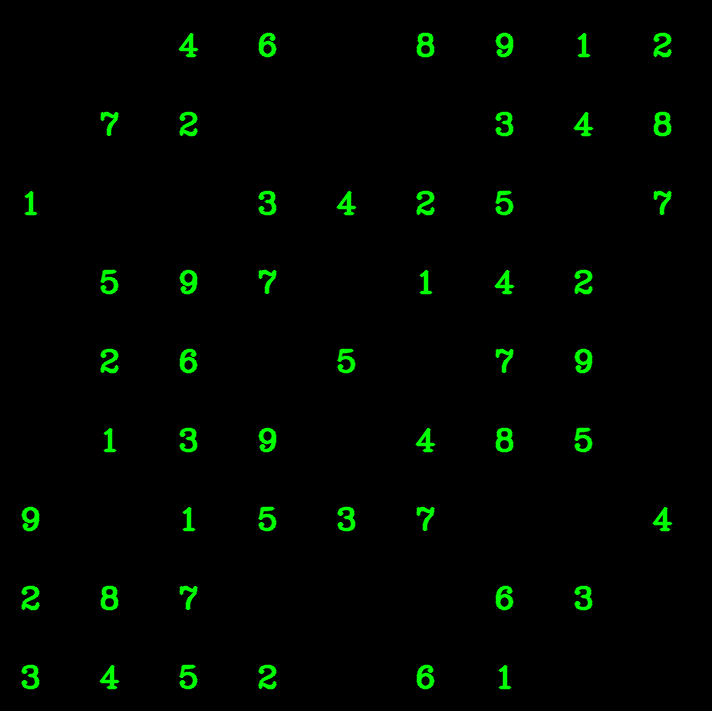

In [446]:
binArr3 = np.where(np.array(unsolved_predicted3)>0, 0, 1)
print(binArr3)
# get only solved numbers for the solved board
flat_solved_board_nums3 = output3.flatten()*binArr3
# create a mask
mask3 = np.zeros_like(board3[1])
solved_board_mask3= displayNumbers(mask3, flat_solved_board_nums3)
cv2_imshow(solved_board_mask3)

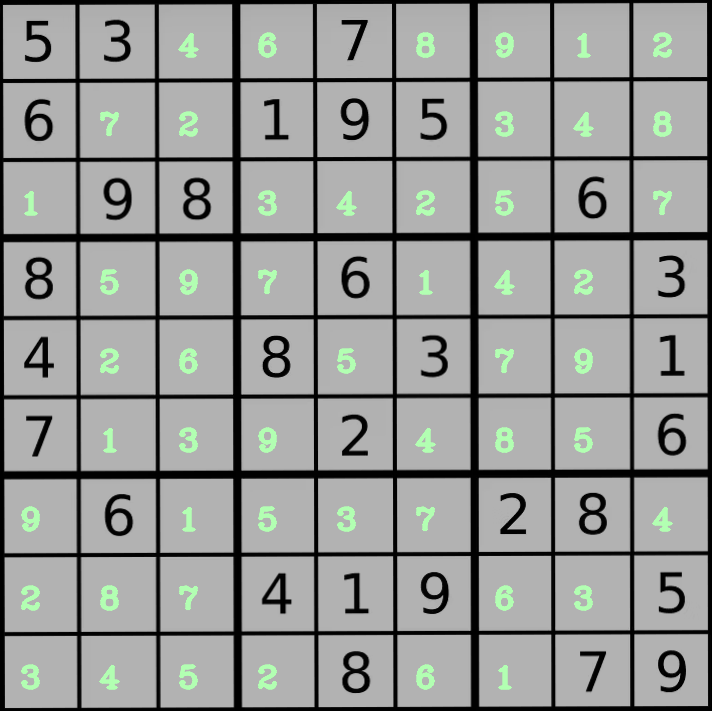

In [447]:
try:
  combined3 = cv2.addWeighted(board3[1], 0.7, solved_board_mask3, 1, 0)
  cv2_imshow(combined3)
  cv2.waitKey(0)
except:
  print("Solution doesn't exist or Model misread digits.")

# **4th Sudoku Board**

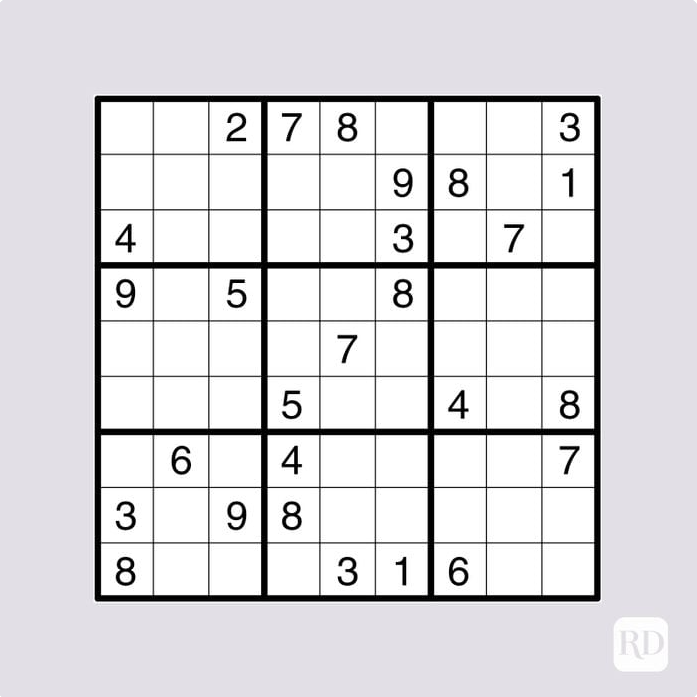

In [448]:
img4 = cv2.imread('/content/sudoku4.png')
original_pic4=(img4)
cv2_imshow(img4)
cv2.waitKey(0)
cv2.destroyAllWindows()

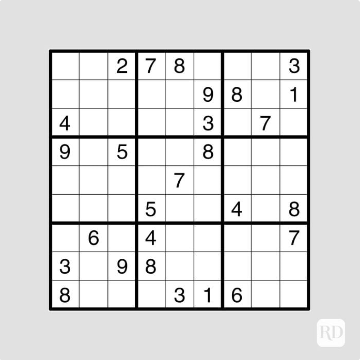

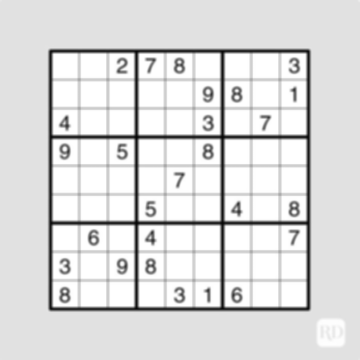

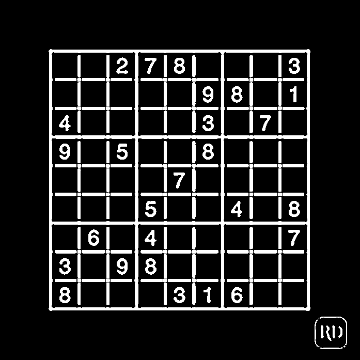

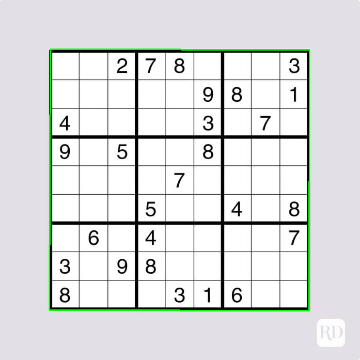

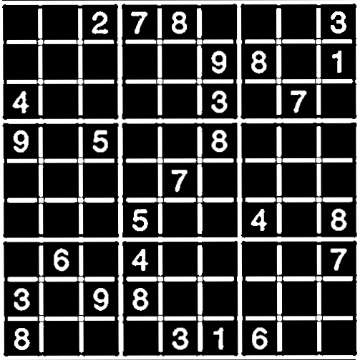

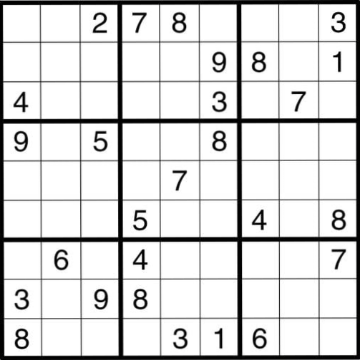

In [449]:
board4= find_board(img4)
cv2_imshow(cv2.resize(board4[1],(360,360)))
cv2.waitKey(0)
cv2.destroyAllWindows()

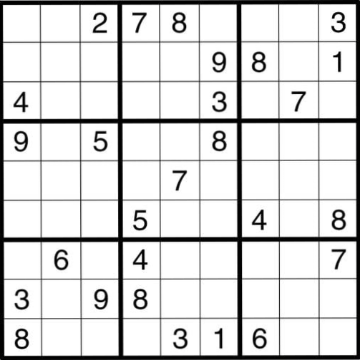

tensor([0])


tensor([0])


tensor([2])


/content/models.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


tensor([7])


tensor([8])


tensor([0])


tensor([0])


tensor([0])


tensor([3])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([9])


tensor([8])


tensor([0])


tensor([1])


tensor([4])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([3])


tensor([0])


tensor([7])


tensor([0])


tensor([9])


tensor([0])


tensor([5])


tensor([0])


tensor([0])


tensor([8])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([7])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([5])


tensor([0])


tensor([0])


tensor([4])


tensor([0])


tensor([8])


tensor([0])


tensor([6])


tensor([0])


tensor([4])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([7])


tensor([3])


tensor([0])


tensor([9])


tensor([8])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([8])


tensor([0])


tensor([0])


tensor([0])


tensor([3])


tensor([1])


tensor([6])


tensor([0])


tensor([0])


In [455]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
unsolved_predicted4=digit_reader(model, device, board4[1],(360,360),(9,9),show=True)
sudoku_array4=unsolved_predicted4.reshape(9,9)

In [451]:
unsolved_predicted4

array([0, 0, 2, 7, 8, 0, 0, 0, 3, 0, 0, 0, 0, 0, 9, 8, 0, 1, 4, 0, 0, 0,
       0, 3, 0, 7, 0, 9, 0, 5, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0,
       0, 0, 0, 0, 5, 0, 0, 4, 0, 8, 0, 6, 0, 4, 0, 0, 0, 0, 7, 3, 0, 9,
       8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 3, 1, 6, 0, 0])

In [452]:
sudoku_array4

array([[0, 0, 2, 7, 8, 0, 0, 0, 3],
       [0, 0, 0, 0, 0, 9, 8, 0, 1],
       [4, 0, 0, 0, 0, 3, 0, 7, 0],
       [9, 0, 5, 0, 0, 8, 0, 0, 0],
       [0, 0, 0, 0, 7, 0, 0, 0, 0],
       [0, 0, 0, 5, 0, 0, 4, 0, 8],
       [0, 6, 0, 4, 0, 0, 0, 0, 7],
       [3, 0, 9, 8, 0, 0, 0, 0, 0],
       [8, 0, 0, 0, 3, 1, 6, 0, 0]])

In [453]:
output4=get_board(sudoku_array4)

[[1 9 2 7 8 4 5 6 3]
 [5 3 7 6 2 9 8 4 1]
 [4 8 6 1 5 3 9 7 2]
 [9 1 5 3 4 8 7 2 6]
 [6 4 8 9 7 2 1 3 5]
 [7 2 3 5 1 6 4 9 8]
 [2 6 1 4 9 5 3 8 7]
 [3 5 9 8 6 7 2 1 4]
 [8 7 4 2 3 1 6 5 9]]


[1 1 0 0 0 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1
 1 1 0 0 0 1 1]


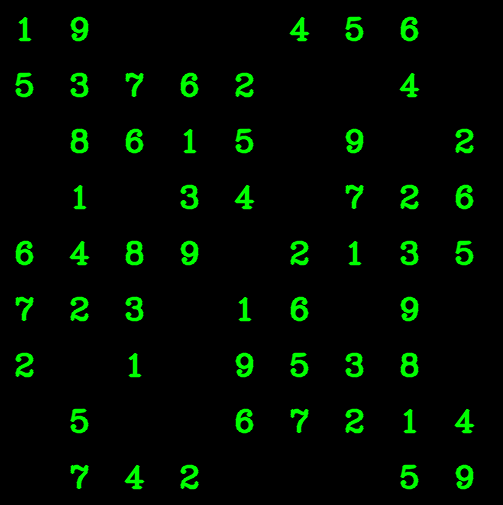

In [456]:
binArr4 = np.where(np.array(unsolved_predicted4)>0, 0, 1)
print(binArr4)
# get only solved numbers for the solved board
flat_solved_board_nums4 = output4.flatten()*binArr4
# create a mask
mask4 = np.zeros_like(board4[1])
solved_board_mask4 = displayNumbers(mask4, flat_solved_board_nums4)
cv2_imshow(solved_board_mask4)

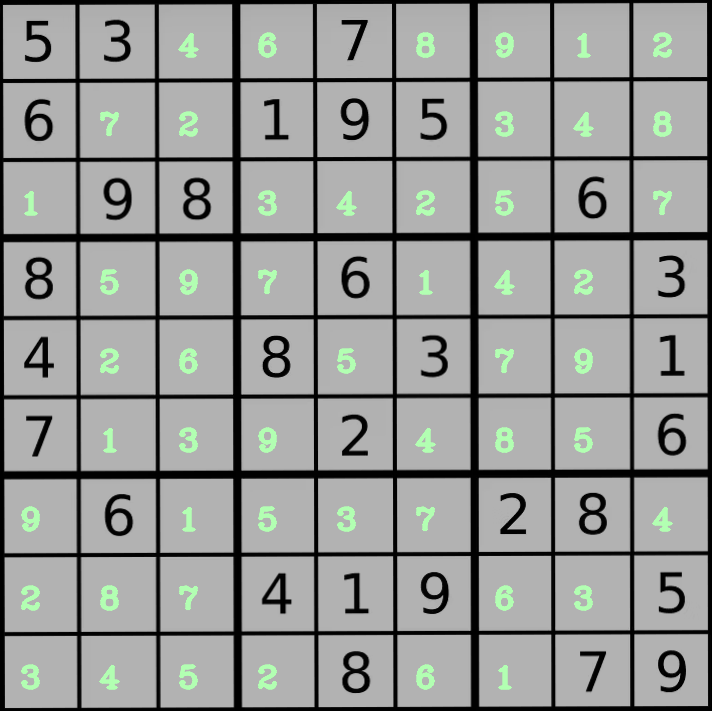

In [457]:
try:
  combined3 = cv2.addWeighted(board3[1], 0.7, solved_board_mask3, 1, 0)
  cv2_imshow(combined3)
  cv2.waitKey(0)
except:
  print("Solution doesn't exist or Model misread digits.")